# Preamble

In [0]:
#Import the different python packages

import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [0]:
#Import the data
tr = pd.read_csv('../input/X_train.csv')
te = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')

# EDA

In [0]:
#View the data
tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [0]:
tr.shape, te.shape

((487680, 13), (488448, 13))

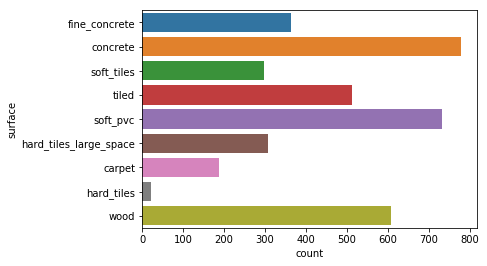

In [0]:
countplot(y = 'surface', data = target)
plt.show()

In [0]:
len(tr.measurement_number.value_counts())

128

In [0]:
tr.shape[0] / 128, te.shape[0] / 128

(3810.0, 3816.0)

## Feature Engineering

In [0]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [0]:
%%time
tr = fe(tr)
te = fe(te)
tr.head()

CPU times: user 1min 20s, sys: 760 ms, total: 1min 21s
Wall time: 1min 20s


In [0]:
tr.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_W_mean,orientation_W_min,orientation_W_max,orientation_W_std,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_mean_change_of_abs_change,orientation_W_abs_max,orientation_W_abs_min,angular_velocity_X_mean,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_std,...,euler_y_mean_abs_change,euler_y_mean_change_of_abs_change,euler_y_abs_max,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,total_angle_mean,total_angle_min,total_angle_max,total_angle_std,total_angle_max_to_min,total_angle_mean_abs_change,total_angle_mean_change_of_abs_change,total_angle_abs_max,total_angle_abs_min,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,-0.63456,-0.63306,0.000471,0.997636,0.000018,0.000000e+00,0.63456,0.63306,-0.105474,-0.106140,-0.104610,0.000432,0.985585,0.000051,7.936508e-08,0.106140,0.104610,-0.106470,-0.107050,-0.105590,0.000389,0.986362,0.000042,4.761905e-07,0.107050,0.105590,-0.002481,-0.16041,0.107650,0.052800,...,0.000065,5.652055e-07,0.025795,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233,101256.698324,100638.015559,102006.152921,378.416210,1.013595,33.501276,0.186413,102006.152921,100638.015559,10296.380999,8090.592033,14292.161203,1122.040965,1.766516,742.697670,3.958445,14292.161203,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,0.24074,0.24270,0.000499,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.031650,0.030504,0.032341,0.000508,1.060222,0.000048,3.253968e-07,0.032341,0.030504,-0.146876,-0.148090,-0.145870,0.000521,0.985009,0.000103,-1.984127e-06,0.148090,0.145870,0.004605,-0.25480,0.283420,0.092309,...,0.000087,3.159478e-10,0.012073,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164,39610.092158,39274.478466,39889.426536,151.936737,1.015658,29.027896,-0.452778,39889.426536,39274.478466,4062.512107,2339.913394,6783.879086,776.901945,2.899201,569.691449,-14.428888,6783.879086,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,-0.84779,-0.84490,0.000785,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,-0.129371,-0.130300,-0.128520,0.000541,0.986339,0.000059,-1.746032e-06,0.130300,0.128520,-0.071082,-0.071535,-0.070378,0.000278,0.983826,0.000044,-1.841270e-06,0.071535,0.070378,0.002646,-0.15271,0.141920,0.060168,...,0.000067,-2.355822e-07,0.012734,0.011795,2.055021,2.049684,

In [0]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [0]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)

In [0]:
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

In [0]:
tr.shape,te.shape, target.shape

((3810, 171), (3816, 171), (3810, 3))

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('all')
tr_sm, target_sm = smote.fit_sample(tr, target.iloc[:,2])
print(tr_sm.shape, target_sm.shape)

Using TensorFlow backend.


(7011, 171) (7011,)


In [0]:
#Replacing SMOTE with originals to see if better preds are obtained without ba
tr_sm = tr
trainset = tr_sm
#trainset = pd.DataFrame.from_records(tr_sm)
trainset.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_W_mean,orientation_W_min,orientation_W_max,orientation_W_std,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_mean_change_of_abs_change,orientation_W_abs_max,orientation_W_abs_min,angular_velocity_X_mean,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_std,...,euler_y_mean_abs_change,euler_y_mean_change_of_abs_change,euler_y_abs_max,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,total_angle_mean,total_angle_min,total_angle_max,total_angle_std,total_angle_max_to_min,total_angle_mean_abs_change,total_angle_mean_change_of_abs_change,total_angle_abs_max,total_angle_abs_min,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,-0.63456,-0.63306,0.000471,0.997636,0.000018,0.000000e+00,0.63456,0.63306,-0.105474,-0.106140,-0.104610,0.000432,0.985585,0.000051,7.936508e-08,0.106140,0.104610,-0.106470,-0.107050,-0.105590,0.000389,0.986362,0.000042,4.761905e-07,0.107050,0.105590,-0.002481,-0.16041,0.107650,0.052800,...,0.000065,5.652055e-07,0.025795,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233,101256.698324,100638.015559,102006.152921,378.416210,1.013595,33.501276,0.186413,102006.152921,100638.015559,10296.380999,8090.592033,14292.161203,1122.040965,1.766516,742.697670,3.958445,14292.161203,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,0.24074,0.24270,0.000499,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.031650,0.030504,0.032341,0.000508,1.060222,0.000048,3.253968e-07,0.032341,0.030504,-0.146876,-0.148090,-0.145870,0.000521,0.985009,0.000103,-1.984127e-06,0.148090,0.145870,0.004605,-0.25480,0.283420,0.092309,...,0.000087,3.159478e-10,0.012073,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164,39610.092158,39274.478466,39889.426536,151.936737,1.015658,29.027896,-0.452778,39889.426536,39274.478466,4062.512107,2339.913394,6783.879086,776.901945,2.899201,569.691449,-14.428888,6783.879086,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,-0.84779,-0.84490,0.000785,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,-0.129371,-0.130300,-0.128520,0.000541,0.986339,0.000059,-1.746032e-06,0.130300,0.128520,-0.071082,-0.071535,-0.070378,0.000278,0.983826,0.000044,-1.841270e-06,0.071535,0.070378,0.002646,-0.15271,0.141920,0.060168,...,0.000067,-2.355822e-07,0.012734,0.011795,2.055021,2.049684,

(3810,)


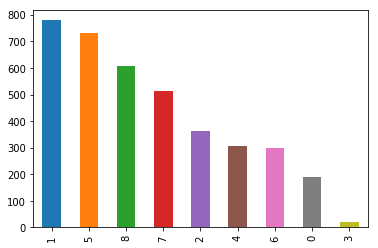

In [0]:
#Convert target variable to target
surface = pd.Series(target["surface"]) #Replaced target_sm with target 
print(surface.shape)
# #Add to trainset
# trainset['surface'] = surface
# #View new triaining dataset
# trainset.head()
surface.value_counts().plot('bar')

# countplot(y = 'surface', data = surface)
# plt.show()

In [0]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

#Original fits
# pca_train = PCA(n_components=2, whiten=True).fit(tr)
# pca_test = PCA(n_components=2, whiten=True).fit(te)

#Transformed fits
# pca = PCA(n_components=2)  
# pca_train = pca.fit_transform(tr)  
# pca_test = pca.transform(te)  

## Both the pcas for the train and test contribute to over 99% of the variation (maybe check the transformations for cetrainty?)
#pca_train.explained_variance_ratio_
#pca_test.explained_variance_ratio_

#view filetype
#type(pca_train)

In [0]:
# from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier(n_estimators = 200, n_jobs = -1)  
# classifier.fit(trainset, surface)

# # Predicting the Test set results
# y_pred = classifier.predict(te)  

-------------------- 0 --------------------
score  0.9142857142857143


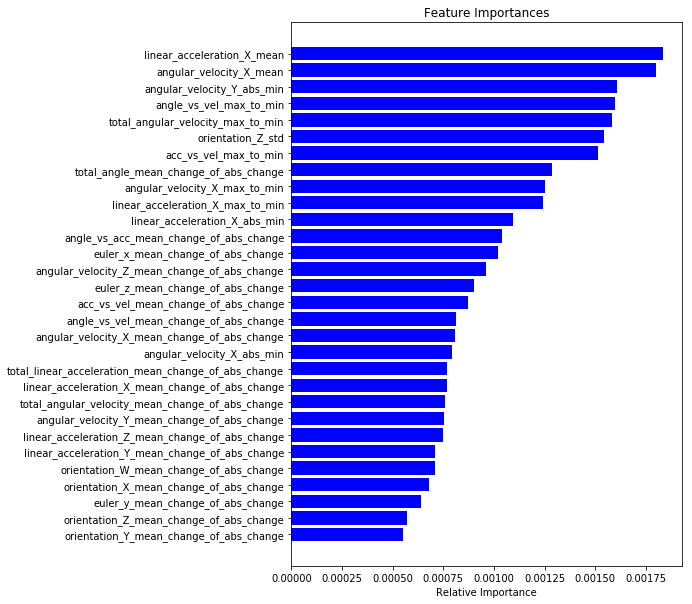

-------------------- 1 --------------------
score  0.8802083333333334


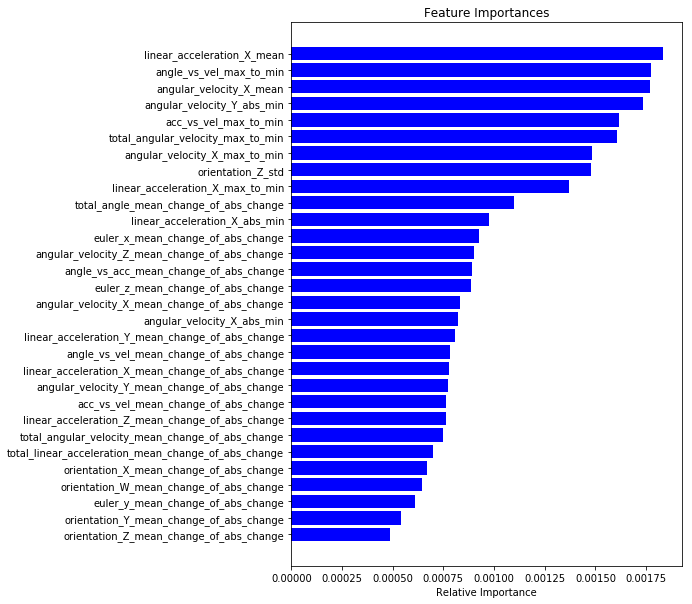

-------------------- 2 --------------------
score  0.9216710182767625


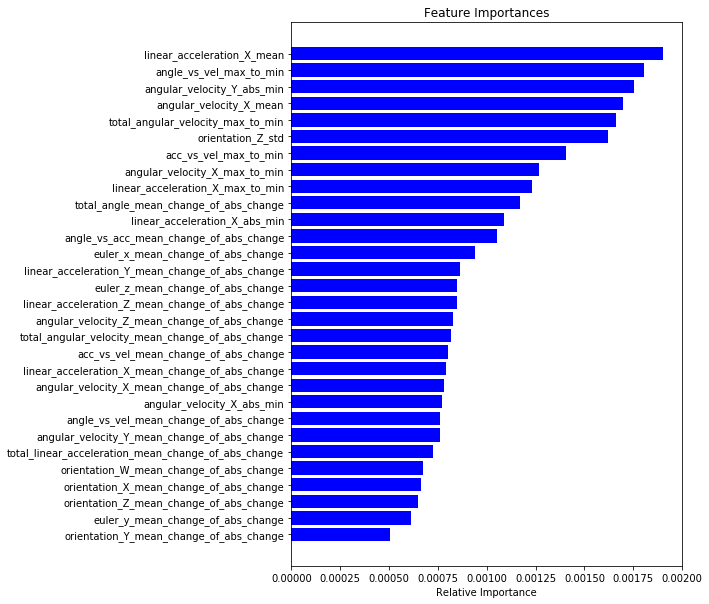

-------------------- 3 --------------------
score  0.9293193717277487


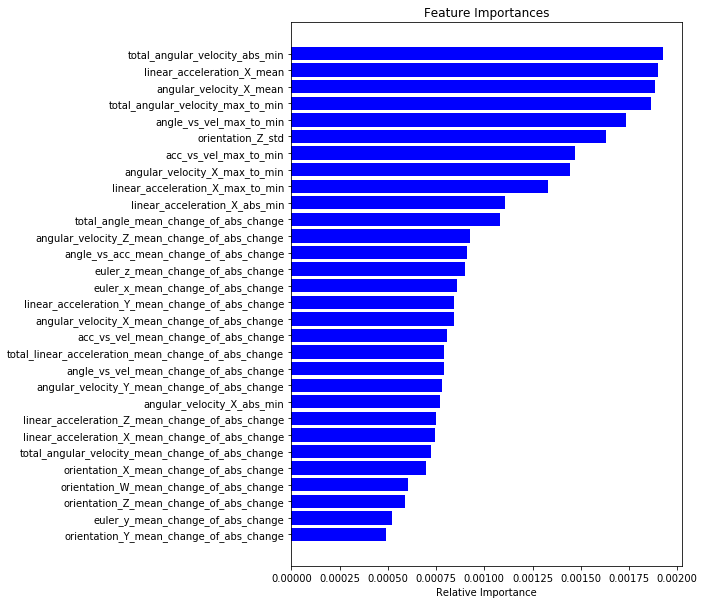

-------------------- 4 --------------------
score  0.9081364829396326


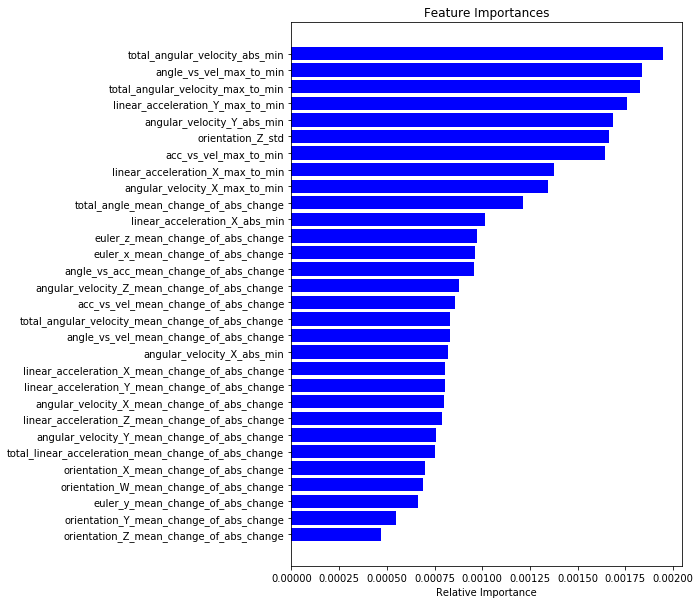

-------------------- 5 --------------------
score  0.9212598425196851


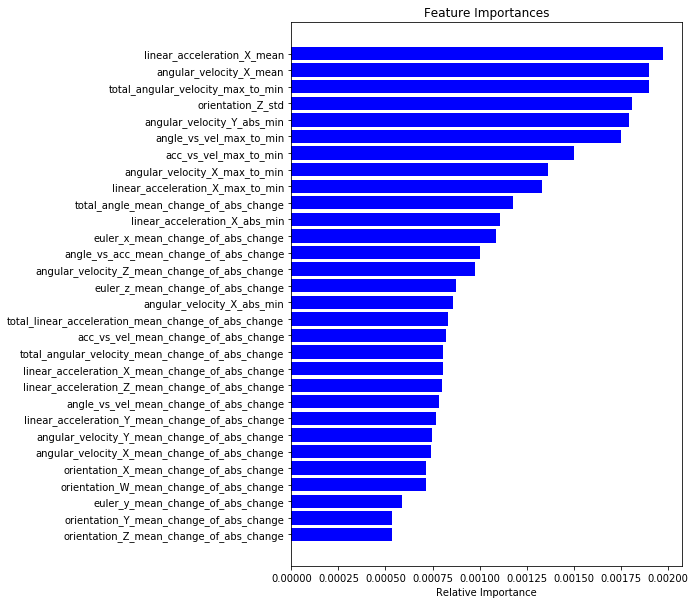

-------------------- 6 --------------------
score  0.868766404199475


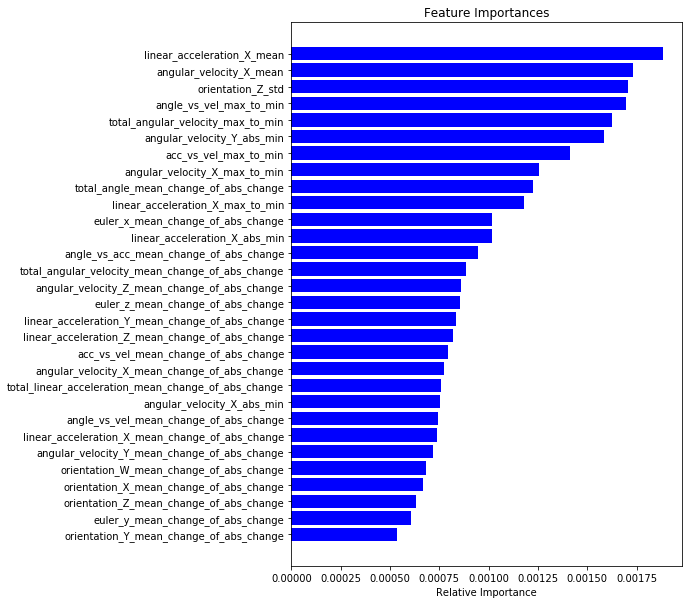

-------------------- 7 --------------------
score  0.8918205804749341


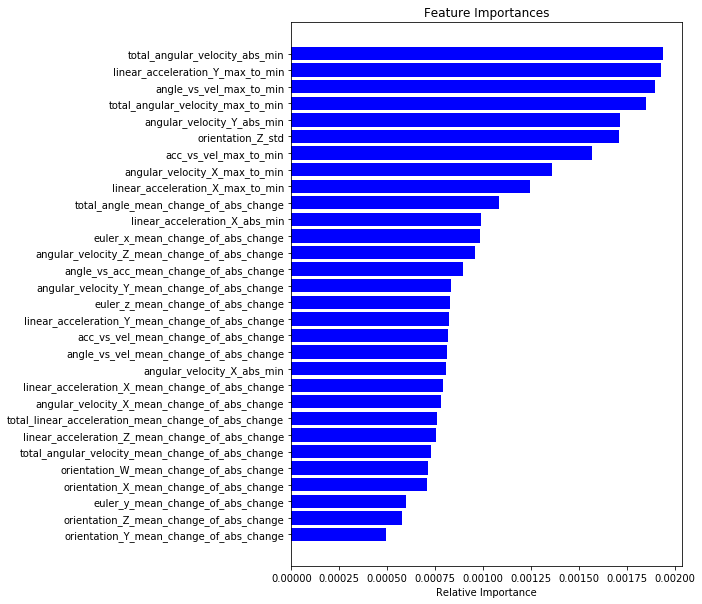

-------------------- 8 --------------------
score  0.9232804232804233


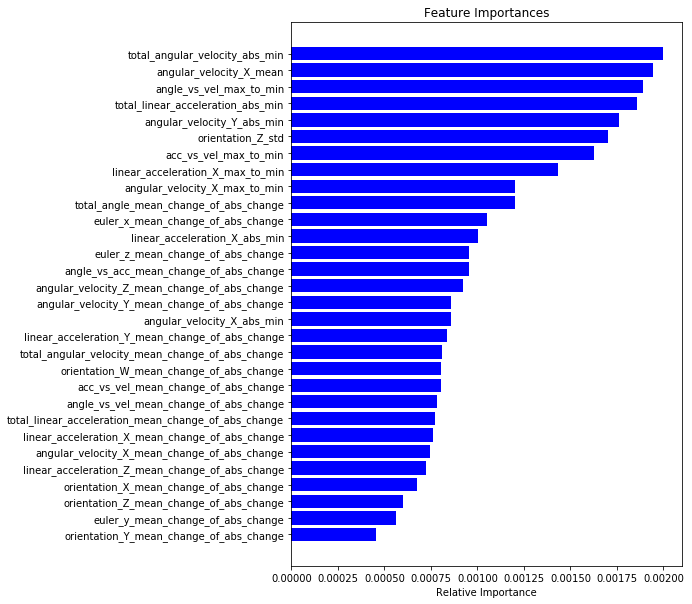

-------------------- 9 --------------------
score  0.8909574468085106


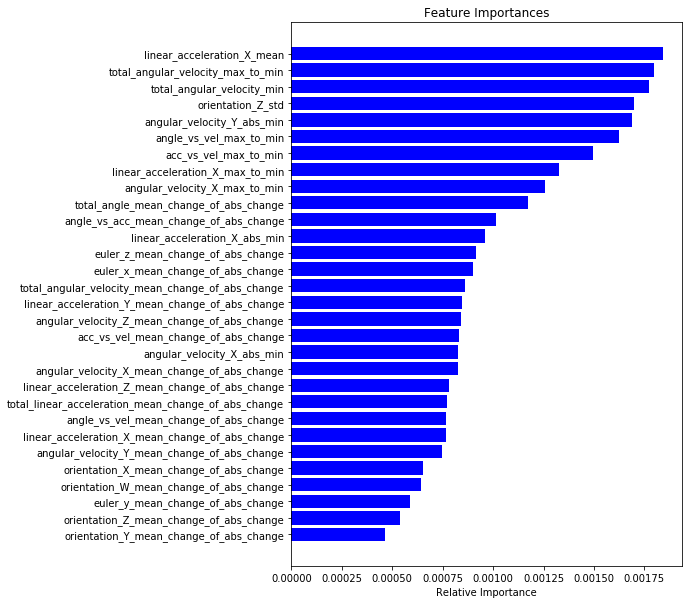

Avg Accuracy 0.9049705617846218


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
#Implement 10 fold kfold validation
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state= 597256869)
sub_preds_rf = np.zeros((te.shape[0], 9))
oof_preds_rf = np.zeros((trainset.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(trainset, surface)):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=1044, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    clf.fit(trainset.iloc[train_index], surface[train_index])
    oof_preds_rf[test_index] = clf.predict(trainset.iloc[test_index])
    sub_preds_rf += clf.predict_proba(te) / folds.n_splits
    score += clf.score(trainset.iloc[test_index], surface[test_index])
    print('score ', clf.score(trainset.iloc[test_index], surface[test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = trainset.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [0]:
# # https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

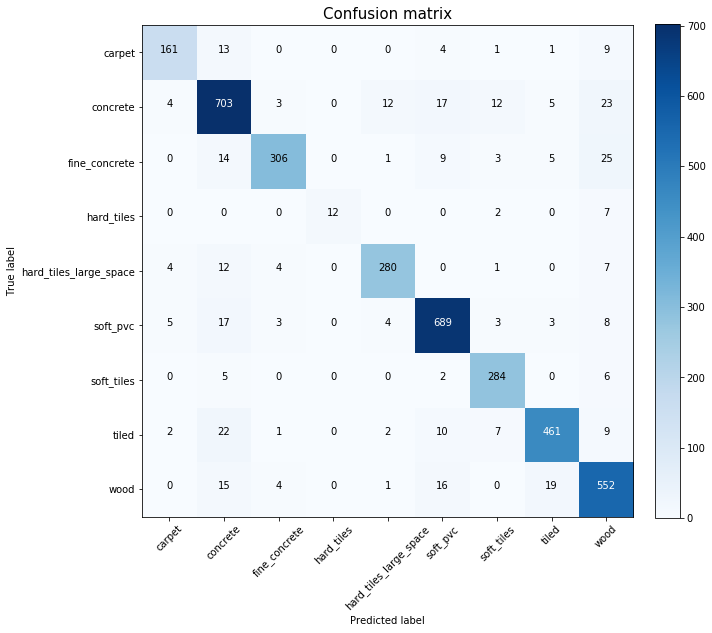

In [0]:
plot_confusion_matrix(surface, oof_preds_rf, le.classes_)

# Submission

In [0]:
predictions = (sub_preds_rf.argmax(axis=1))
preds = le.inverse_transform(predictions)
focus = pd.DataFrame.from_records(preds)
focus.to_csv('balancedpreds.csv', index=False)